# Pulse Sandbox - create pulses instead of a continuous signal

In [95]:
import matplotlib.pyplot as plt

from pynq import Overlay
import numpy as np

from qsystem_2 import *
from qsystem2_asm import *

In [96]:
soc = PfbSoc('qsystem_2.bit', force_init_clks=False)
with ASM_Program() as p:
    #Write all memory addresses to program memory
    p.memri(1,1,0,"Loop")
    #Set the frequencies for each channel
    p.memri(0,1,1,"freq ch 1")
    p.memri(0,2,2,"freq ch 2")
    p.memri(0,3,3,"freq ch 3")
    p.memri(0,4,4,"freq ch 4")
    p.memri(0,5,5,"freq ch 5")
    p.memri(0,6,6,"freq ch 6")
    p.memri(0,7,7,"freq ch 7")
    #Set the gain values for each channel
    p.memri(0,8,8,"gain ch 1")
    p.memri(0,9,9,"gain ch 2")
    p.memri(0,10,10,"gain ch 3")
    p.memri(0,11,11,"gain ch 4")
    p.memri(0,12,12,"gain ch 5")
    p.memri(0,13,13,"gain ch 6")
    p.memri(0,14,14,"gain ch 7")
    #Set the nsamp and nsync variables from address memory
    p.memri(0,15,15,"nsamp")
    p.memri(1,2,16,"nsync")
    #Set up nsamp and DAC selection register. 
    p.regwi(0,16,0b1001,"0b1001, stdysel = 1 (zero value), mode = 0 (nsamp), outsel = 01 (dds).")
    p.bitwi(0,16,16, "<<", 16)
    p.bitw(0,15,15,"|",16)
    #Delay the start a bit
    p.synci(1000)
    #Trigger value for the average block. 
    p.regwi(1,3, 0xC001) 
    p.seti(0,1,3,0)
    #Loop
    p.label("LOOP")
    p.set(1,0,1,0,0, 8,15,0)
    p.set(2,0,2,0,0, 9,15,0)
    p.set(3,0,3,0,0,10,15,0)
    p.set(4,0,4,0,0,11,15,0)
    p.set(5,0,5,0,0,12,15,0)
    p.set(6,0,6,0,0,13,15,0)
    p.set(7,0,7,0,0,14,15,0)
    p.sync(1,2)
    p.loopnz(1,1,"LOOP")
    #End the signal
    p.seti(0,0,0,0)
soc.tproc.load_asm_program(p)

In [138]:
#Sends a pulse at the given frequency (freq) for the given time (nsamp) with the given gain (gain)
#and reads back a signal from the average buffer that is 1.3 times the duration (nsamp). 
#This is repeated (loop) times. 

debugMode = False
enablePrintSignature = True
enablePrintBuffers = False
enablePrintAverages = False
enableTestFunction = False

def pulseGenerator (freq=150, gain=30000, pulseWidth=150, delay=100, pulseCount=3, outputType="product"):
    
    if enablePrintSignature: 
        print(f"DAC/DDS Frequency: {freq}")
        print(f"ADC Gain: {gain}")
        print(f"Number of Samples: {pulseWidth}")
        print(f"Loop Count: {pulseCount}")
        print(f"Input Type: {outputType}")
    
    #Set the address register space. 
    #Format the numbers and send them to the tproc for output frequency
    freqRegDAQ = freq2reg(soc.fs_dac, freq, B=32)
    soc.tproc.single_write(addr=7, data = freqRegDAQ)
    if debugMode: print(f"Output Frequency DAC: {freqRegDAQ}")
    #Simply write to the nsamp address WITHOUT formatting. (It is assumed that the user will do this)
    soc.tproc.single_write(addr=15, data = pulseWidth)
    if debugMode: print(f"nsamp: {nsamp}")
    #Write the size  of the pulse on the ADC domain (nSync). This is defined to be 1.3 times the duration (nsamp)
    nsync = int(pulseWidth + delay) #With no multiplier, there will be no delay between pulses. 
    soc.tproc.single_write(addr=16, data = nsync)
    if debugMode: print(f"nsync: {nsync}")
    #Write the loop iteration count (Loop). It should be noted that the loop iteration variable must be loopCount-1. 
    soc.tproc.single_write(addr=0, data = pulseCount-1)
    if debugMode: print(f"loop: {pulseCount}")
    #Write output gain WITHOUT formatting to the output gain address. 
    soc.tproc.single_write(addr=14, data = gain)
    if debugMode: print(f"gain: {gain}")
    
    #Set the size of the average buffer to nsamp (number of decimated samples) and enable the buffer. 
    adcChannel=0
    soc.readouts[adcChannel].set_out(outputType)
    soc.readouts[adcChannel].set_freq(freq)
    soc.avg_bufs[adcChannel].config(address = adcChannel, length = int(1000))
    soc.avg_bufs[adcChannel].enable()
    if debugMode: print(f"Average Buffer Length: {nsamp}")
    
    #Start tProc
    #soc.setSelection("product")
    soc.tproc.stop()
    soc.tproc.start()
    
    #Get I/Q decimated samples with the length loop * nsync where nsync is the number of decimated samples and 
    decimatedLength = pulseCount * pulseWidth
    #idec,qdec = soc.get_decimated(ch=0, length = (loop) * nsamp)
    try:
        idec,qdec = soc.get_decimated(ch=0, length = 1000)
        if enablePrintBuffers:

            #Plot everything. 
            fig,ax = plt.subplots(2, 1, sharex=True)
            ax[0].plot(idec)
            ax[0].set_ylabel("I")
            ax[1].plot(qdec)
            ax[1].set_ylabel("Q")
            ax[1].set_xlabel("Sample Number")
            ax[0].set_title("Decimated Samples")
    except RuntimeError as e:
        idec,qdec = None,None
        print("Trouble reading decimated values",e)
        
    #Get I/Q accumulated samples with the number of loop iterations. 
    try:
        iacc,qacc =  soc.get_accumulated(ch=0, length=pulseCount)
    except RuntimeError as e:
        iacc,qacc = None,None
        print("Trouble reading accumulated values",e)
    
    if enablePrintAverages: 
        #Get the absolute value of the I and Q values
        absValues = np.sqrt(iacc ** 2 + qacc ** 2)

        #Get the phase for each sample
        phases = np.arctan2(qacc, iacc)

        #Plot everything. 
        fig,ax = plt.subplots(4,1,sharex=True)
        ax[0].plot(iacc, "*-")
        ax[0].set_ylabel("I")
        ax[1].plot(qacc, "*-")
        ax[1].set_ylabel("Q")
        ax[2].plot(absValues, "*-")
        ax[2].set_ylabel("Abs Values")
        ax[3].set_xlabel("sample number")
        ax[3].plot(phases, "*-")
        ax[3].set_ylabel("Phases")
        ax[0].set_title("from getAccumulated")
    
    return idec, qdec, iacc, qacc

DAC/DDS Frequency: 2000
ADC Gain: 30000
Number of Samples: 10
Loop Count: 10
Input Type: product
Trouble reading accumulated values DMA channel not started


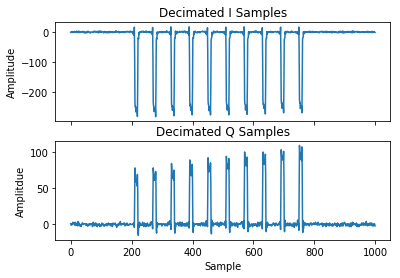

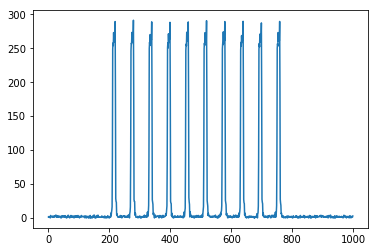

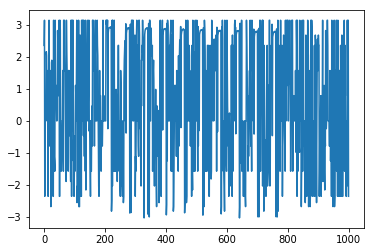

In [143]:
pulseWidth = 10
pulseDelay = 50
pulseCount = 10
freq = 2000
outputType = "product"
gain = 30000

idec, qdec, iacc, qacc = pulseGenerator(freq=freq, 
                                        gain=gain, 
                                        pulseWidth=pulseWidth, 
                                        delay=pulseDelay,
                                        pulseCount=pulseCount, 
                                        outputType=outputType)

if idec is not None:
    fig,ax = plt.subplots(2,1,sharex=True)
    ax[0].plot(idec)
    ax[0].set_title("Decimated I Samples")
    ax[0].set_ylabel("Amplitude")
    ax[1].plot(qdec)
    ax[1].set_title("Decimated Q Samples")
    ax[1].set_ylabel("Amplitdue")
    ax[1].set_xlabel("Sample")
    '''
    for i in range(0, iterations):
        ax[0].axvline(nsamp * (i+1), color="r", alpha=0.25)
        ax[1].axvline(nsamp * (i+1), color="r", alpha=0.25)
    '''
    plt.show()
    
plt.plot(np.abs(idec + 1j * qdec))
plt.show()

plt.plot(np.angle(idec + 1j * qdec))
plt.show()

if iacc is not None:
    fig,ax = plt.subplots(2,1,sharex=True)
    ax[0].plot(iacc)
    ax[0].set_title("I Accumulated Samples")
    ax[0].set_ylabel("Amplitude")
    ax[1].plot(qacc)
    ax[1].set_title("Q Accumulated Samples")
    ax[1].set_ylabel("Amplitude")
    ax[1].set_xlabel("Sample")
    plt.show()